# Introduction
A [median filter](https://en.wikipedia.org/wiki/Median_filter) is a non-linear operation that replaces the value of a pixel by the median value of it's neighbors. It can be very useful for removing [salt and pepper noise](https://en.wikipedia.org/wiki/Salt-and-pepper_noise) from images. It's not uncommon to see "salt" when a cosmic ray hits your camera detector (*e.g.*, a pixel on an sCMOS chip). That type of noise will really mess up any downstream processing algorithms, because they usually don't assume the presence of such noise. Unfortunately, median filters are *very* slow, so it's not always practical to use them in a data analysis pipeline. So, I've done a little digging into how to speed them up for my Python code.  

# Literature

This follows the following two works: 

* Huang, T.S., Yang, G.J., Tang, G.Y. *A Fast Two-Dimensional Median Filtering Algorithm*. IEEE Transactions on Acoustics, Speech, and Signal Processing, 27(1), 1979.
* Perreault, S., Hebert, P. *Median Filtering in Constant Time*. IEEE Transactions on Image Processing, 16, 2389–2394, 2007.

n.b., the Perreault manuscript reviews the Huang median filter.

# Code
Here's some non-optimized code to perform both the Huang and Perreault median filters on 2D, 8-bit images. Both of these are histogram-based median filters, where the idea is the the median value is found from a histogram instead of using a sorting filter. This means that, here, I'm maintaining an 256-bin histogram and looping through it until the cumulative counts reach 50% of the total counts. Also, w is the width of the kernel window, and must be an odd number. For the edges, they are treated as just having smaller neighborhoods.

In [1]:
import numpy as np
import numba as nb


@nb.njit
def med_huang_boundary(dd,w):
	nx,ny = dd.shape
	filtered = np.zeros_like(dd)
	histogram = np.zeros(256,dtype='int')
	w2 = int(w*w)
	r = int((w-1)//2)

	for i in range(nx):

		### zero histogram
		for hi in range(256):
			histogram[hi] = 0
		
		### initialize histogram
		j = 0
		nn = 0
		for k in range(-r,r+1):
			for l in range(-r,r+1):
				hi = i+k
				hj = j+l
				if hi >=0 and hj>=0 and hi<nx and hj<ny:
					histogram[dd[hi,hj]] += 1
					nn += 1

		## find median of histogram
		cut = int((nn//2)+1)
		count = 0
		for ci in range(histogram.size):
			count += histogram[ci]
			if count >= cut:
				filtered[i,j] = ci
				break

		### run row
		for j in range(1,ny):
			hjl = j-r -1
			hjr = j+r
				
			for k in range(-r,r+1):
				hi = i+k
				## add RHS histogram
				if hi >=0 and hi<nx and hjr<ny:
					histogram[dd[hi,hjr]] += 1
					nn += 1
				## remove LHS histogram
				if hi >=0 and hjl>=0 and hi<nx:
					histogram[dd[hi,hjl]] -= 1
					nn -= 1

			## find median of histogram
			cut = int((nn//2)+1)
			count = 0
			for ci in range(histogram.size):
				count += histogram[ci]
				if count >= cut:
					filtered[i,j] = ci
					break
	return filtered

@nb.njit
def med_perreault_boundary(dd,w):
	nx,ny = dd.shape
	filtered = np.zeros_like(dd)
	kernel_histogram = np.zeros(256,dtype='int')
	nn = 0
	column_histograms = np.zeros((ny,256),dtype='int')
	nnc = np.zeros(ny,dtype='int')
	
	w2 = int(w*w)
	r = int((w-1)//2)

	######### Initialize things
	i = 0
	j = 0
	
	##initialize column histograms
	for j in range(ny):
		for k in range(r+1):
			column_histograms[j,dd[k,j]] += 1
			nnc[j] += 1
	
	## initialize kernel histogram
	for l in range(r+1):
		kernel_histogram += column_histograms[l]
		nn += nnc[l]
	
	### first row doesn't get updates
	for j in range(ny):
		if j > 0:
			hjl = j - r - 1
			hjr = j + r
			if hjl >= 0:
				kernel_histogram -= column_histograms[hjl]
				nn -= nnc[hjl]
			if hjr < ny:
				kernel_histogram += column_histograms[hjr]
				nn += nnc[hjr]
			
		cut = int((nn//2)+1)
		count = 0
		
		for ci in range(kernel_histogram.size):
			count += kernel_histogram[ci]
			if count >= cut:
				filtered[i,j] = ci
				break

	######### Do Rows 
	for i in range(1,nx):
		for j in range(ny):
			## start the next row
			if j == 0:
				kernel_histogram *= 0
				nn = 0
				hit = i-r-1
				hib = i+r
				for l in range(r+1):
					if hit >= 0:
						column_histograms[l,dd[hit,l]] -= 1
						nnc[l] -= 1
					if hib < nx:
						column_histograms[l,dd[hib,l]] += 1
						nnc[l] += 1
					kernel_histogram += column_histograms[l]
					nn += nnc[l]
			
			## go through the row
			else:
				hit = i-r-1
				hib = i+r
				hjl = j-r-1
				hjr  = j+r

				#### update column histograms
				## top
				if hit >= 0:
					column_histograms[hjr,dd[hit,hjr]] -= 1
					nnc[hjr] -= 1

				## bottom
				if hib < nx:
					column_histograms[hjr,dd[hib,hjr]] += 1
					nnc[hjr] += 1

				#### update kernel histogram
				## left
				if hjl >= 0:
					kernel_histogram -= column_histograms[hjl]
					nn -= nnc[hjl]

				## right
				if hjr < ny:
					kernel_histogram += column_histograms[hjr]
					nn += nnc[hjr]
					
			
			## find median of kernel histogram
			cut = int((nn//2)+1)
			count = 0
			for ci in range(kernel_histogram.size):
				count += kernel_histogram[ci]
				if count >= cut:
					filtered[i,j] = ci
					break

	return filtered

# Timing 
A sorting-based median filter scales with the size of the kernel window, i.e., $\mathcal{O}(r^2)$, where $2r+1$ is width of the kernel. Ignoring all overhead, and some issues with the edges, the Huang median filter scales with $\mathcal{O}(r)$, and the Perreault median filter scales with $\mathcal{O}(1)$. For Perreault, that means it is constant time WRT to kernel size -- obviously, for all of these median filters, the larger the image, the larger the processing time.

Here's a quick investigation of the timing

In [2]:
##### Simulate image
from scipy.ndimage import uniform_filter,gaussian_filter
nx,ny = (1024,1024)

## Make some blurry features
d = np.random.seed(666)
d = (np.random.rand(nx,ny)*256).astype('uint8')
d = uniform_filter(d,8)
d += (np.random.poisson(d.astype('double')*500)//100).astype('uint8')
d = gaussian_filter(d,8).astype('uint8')

## Add salt and pepper noise
dd = d.copy()
dd[np.random.rand(nx,ny)>.995] = 255
dd[np.random.rand(nx,ny)>.995] = 0


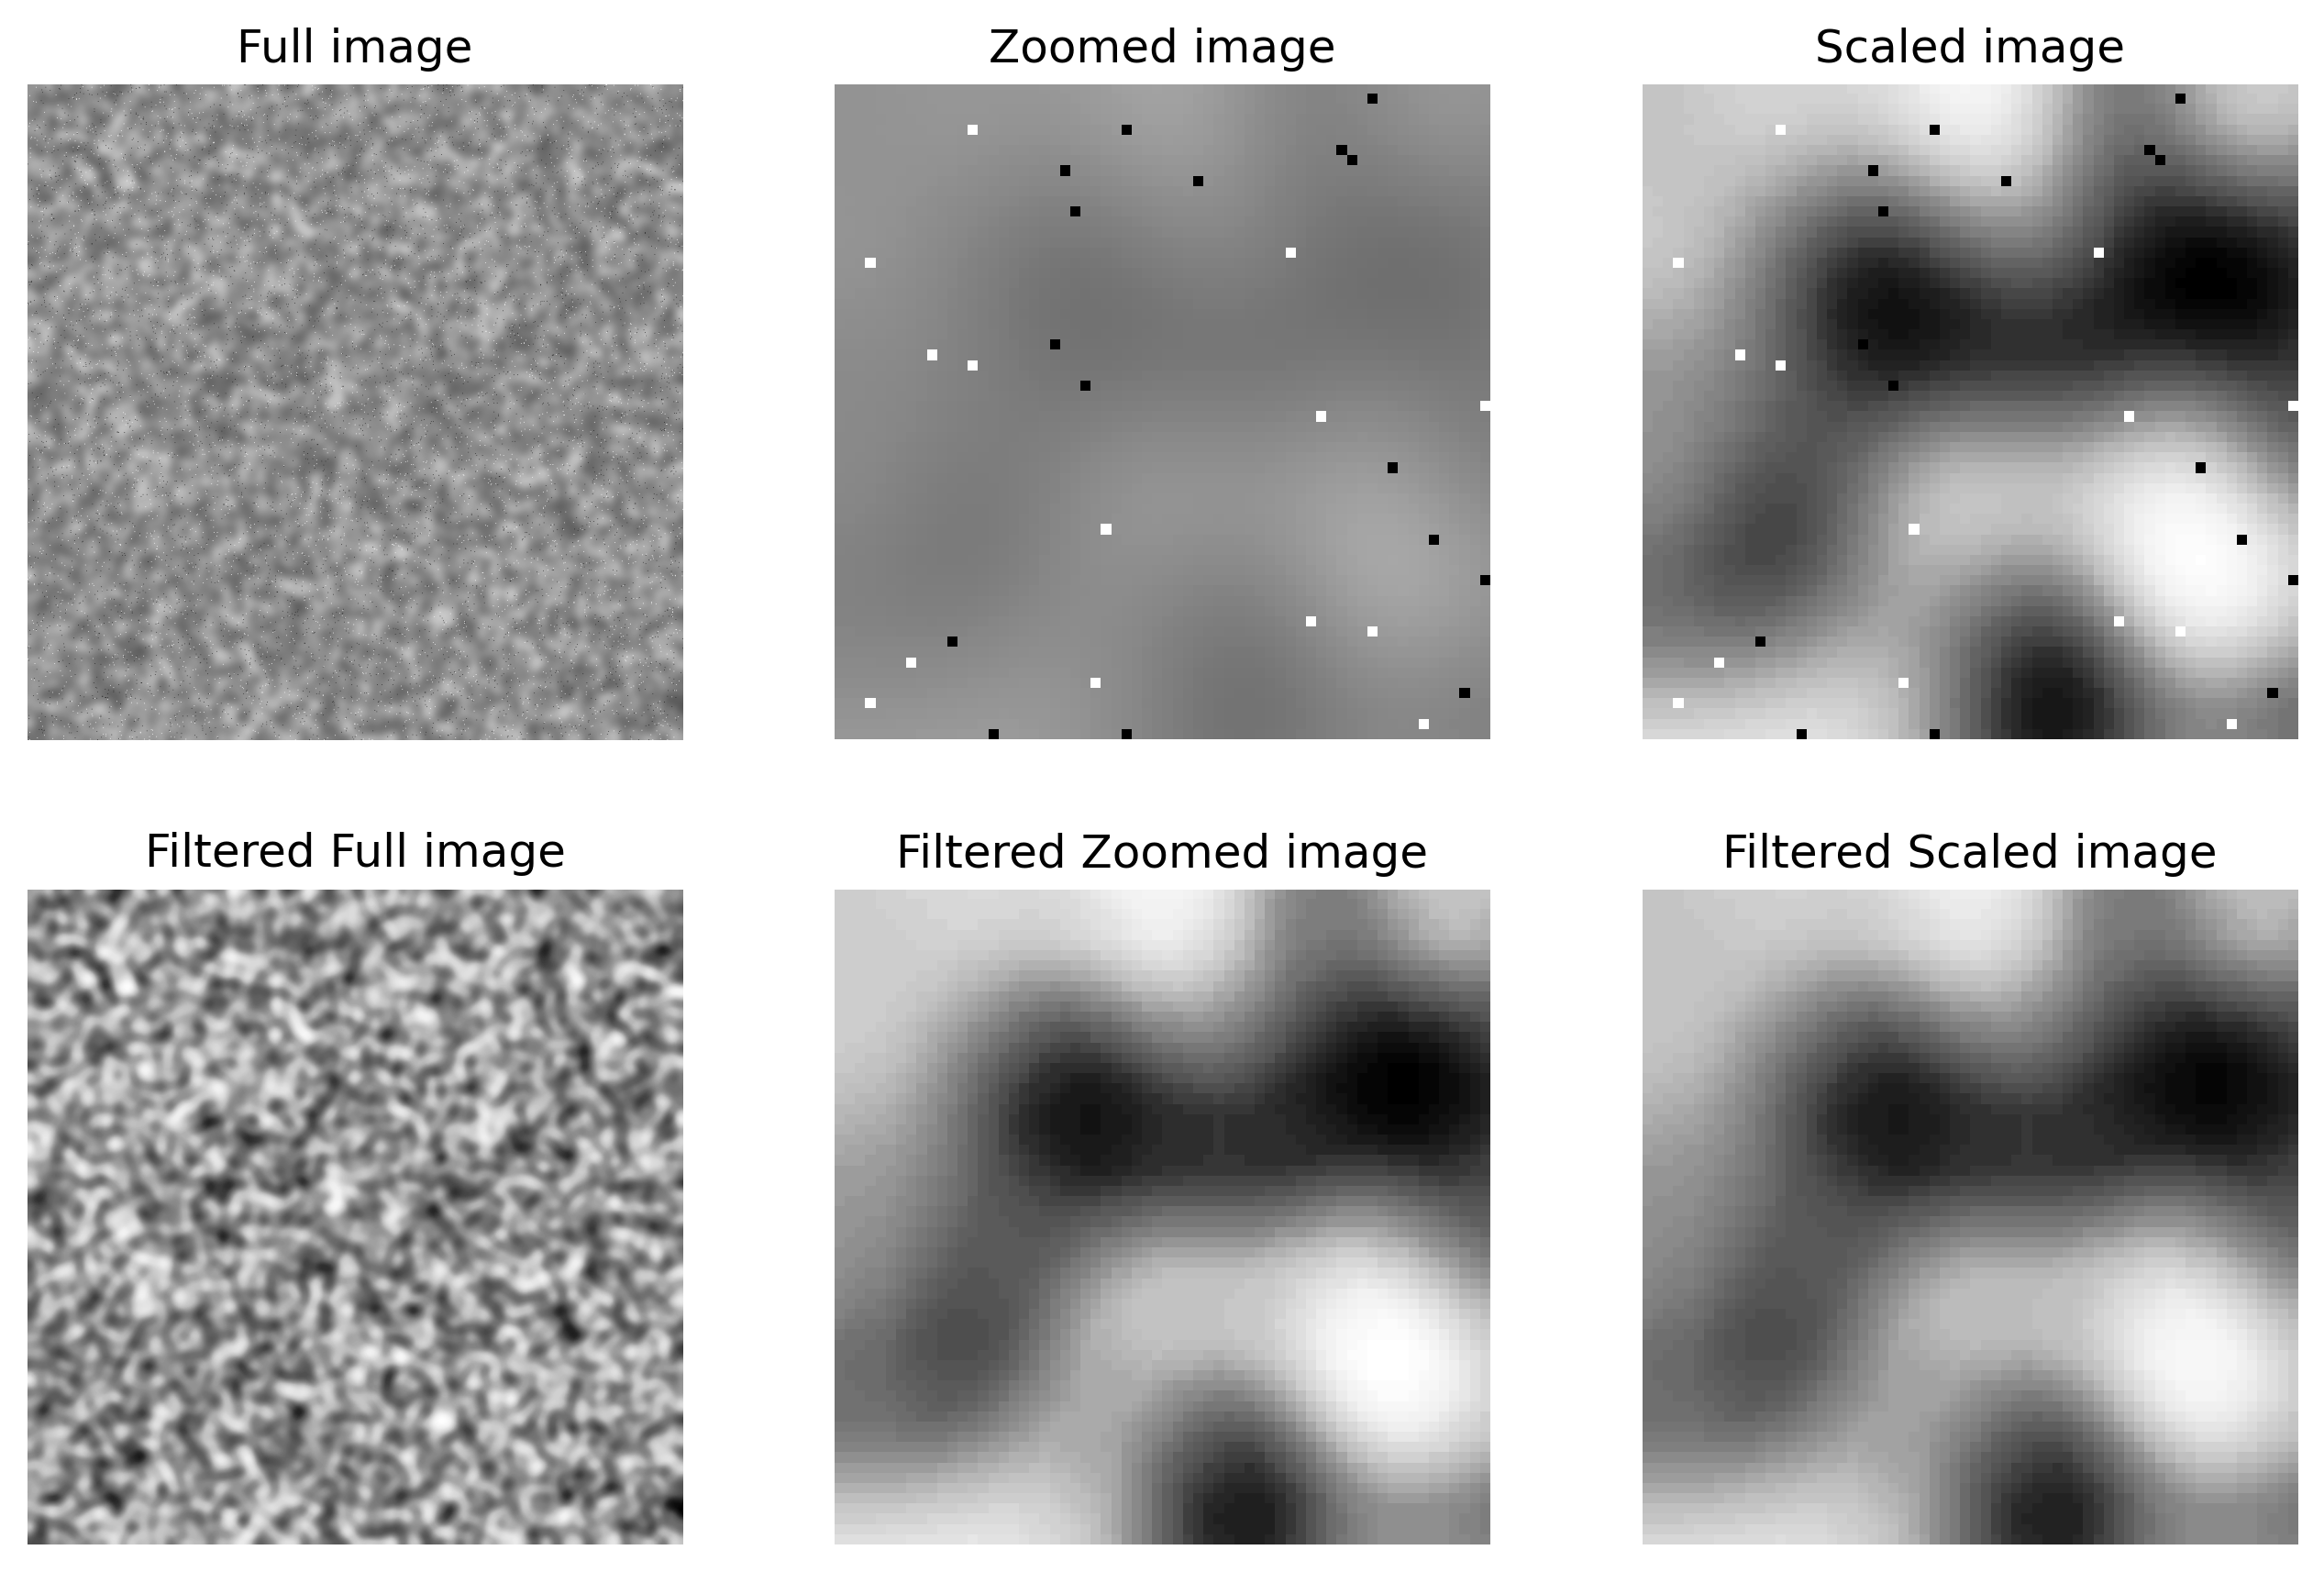

In [3]:
#### Plot the Image
import matplotlib.pyplot as plt

zoom = 64
vmin = d[:zoom,:zoom].min()
vmax = d[:zoom,:zoom].max()

fig,ax = plt.subplots(2,3,figsize=(9,6),dpi=300)
#### Image
ax[0,0].imshow(dd,cmap='Greys')
ax[0,1].imshow(dd[:zoom,:zoom],cmap='Greys',interpolation='nearest')
ax[0,2].imshow(dd[:zoom,:zoom],cmap='Greys',interpolation='nearest',vmin=vmin,vmax=vmax)

#### Median filtered image
q = med_huang_boundary(dd,9)
ax[1,0].imshow(q,cmap='Greys')
ax[1,1].imshow(q[:zoom,:zoom],cmap='Greys',interpolation='nearest')
ax[1,2].imshow(q[:zoom,:zoom],cmap='Greys',interpolation='nearest',vmin=vmin,vmax=vmax)

ax[0,0].set_title('Full image')
ax[0,1].set_title('Zoomed image')
ax[0,2].set_title('Scaled image')

ax[1,0].set_title('Filtered Full image')
ax[1,1].set_title('Filtered Zoomed image')
ax[1,2].set_title('Filtered Scaled image')

fig.tight_layout()
[[aaa.axis('off') for aaa in aa] for aa in ax]
plt.show()

In [4]:
import time
from tqdm.notebook import tqdm
from scipy.ndimage import median_filter

iters = 10

ws = np.arange(1,251)*2+1
times = np.zeros((3,ws.size)) + np.nan

#### Huang's median filter
for i in tqdm(range(100),desc='Huang'):
	ts = []
	for _ in range(iters):
		t0 = time.time()
		med_huang_boundary(dd,ws[i])
		t1 = time.time()
		ts.append(t1-t0)
		times[1,i] = np.median(ts)
	# print(i,ws[i],times[1,i])
# print('Done Huang')

#### Perreault's median filter
for i in tqdm(range(ws.size),desc='Perreault'):
	ts = []
	for _ in range(iters):
		t0 = time.time()
		med_perreault_boundary(dd,ws[i])
		t1 = time.time()
		ts.append(t1-t0)
		times[2,i] = np.median(ts)
	# print(i,ws[i],times[2,i])
# print('Done Perreault')

##### Scipy's median filter (from ndimage)
for i in tqdm(range(20),desc='Scipy'):
	ts = []
	for _ in range(iters//2):
		t0 = time.time()
		median_filter(dd,ws[i])
		t1 = time.time()
		ts.append(t1-t0)
		times[0,i] = np.median(ts)
	# print(i,ws[i],times[0,i])
# print('Done Scipy')


Huang:   0%|          | 0/100 [00:00<?, ?it/s]

Perreault:   0%|          | 0/250 [00:00<?, ?it/s]

Scipy:   0%|          | 0/20 [00:00<?, ?it/s]

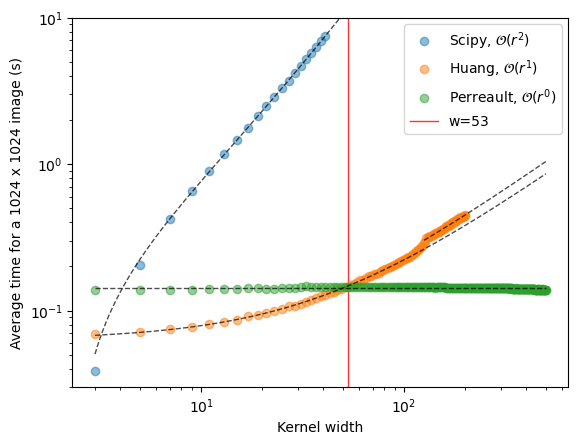

In [25]:
plt.plot(ws,times[0],label='Scipy, $\mathcal{O}(r^2)$',lw=1.5,marker='o',alpha=.5,linestyle='none')
plt.plot(ws,times[1],label='Huang, $\mathcal{O}(r^1)$',lw=1.5,marker='o',alpha=.5,linestyle='none')
plt.plot(ws,times[2],label='Perreault, $\mathcal{O}(r^0)$',lw=1.5,marker='o',alpha=.5,linestyle='none')

p0 = np.polyfit(ws[np.isfinite(times[0])],times[0][np.isfinite(times[0])],2)
p1 = np.polyfit(ws[ws<100],times[1][ws<100],1)
keep = np.bitwise_and(np.isfinite(times[1]),ws>125)
p1b = np.polyfit(ws[keep],times[1][keep],1)
p2 = np.polyfit(ws,times[2],0)

x = np.logspace(np.log10(3),np.log10(ws[-1]),1000)
y0 = p0[0]*x*x + p0[1]*x + p0[2]
y1 = p1[0]*x + p1[1]
y1b = p1b[0]*x + p1b[1]
y2 = p2[0] + (x*0)
plt.plot(x,y0,color='k',lw=1,ls='--',alpha=.7)
plt.plot(x,y1,color='k',lw=1,ls='--',alpha=.7)
plt.plot(x[x>125],y1b[x>125],color='k',lw=1,ls='--',alpha=.7)
plt.plot(x,y2,color='k',lw=1,ls='--',alpha=.7)

diff = np.square(times[1]-times[2])
switch = ws[diff[np.isfinite(diff)].argmin()]
plt.axvline(x=switch,label='w=%d'%(switch),color='red',linewidth=1,alpha=.8,zorder=-2)
# plt.axvline(x=125,color='k',linewidth=1,ls='--',alpha=.7)

plt.xlabel('Kernel width')
plt.ylabel('Average time for a %d x %d image (s)'%(dd.shape[0],dd.shape[1]))
plt.legend()
plt.ylim(.03,10)
# plt.xlim(0,201)
plt.yscale('log')
plt.xscale('log')
plt.show()

# Conclusions
As you can seen in the plot of the timing, this Python code matches the theoretical scaling WRT the kernel size ($r^2$, $r^1$ and $r^0$). It also replicates the cross-over point between the Huang and Perreault approaches from the Perreault paper. As they explain, this is largely because of the overhead associated with initializing the column histograms in Perreault's approach.

Overall, this isn't very optimized Python code, which is part of why the Scipy filter is the fastest for a 3x3 kernel -- however, that quickly becomes very slow. 

I am planing to use these to remove salt and pepper noise for spot finding in single-molcule localization microscopy.